# K Nearest Neighbour algorithm
## Imports
Relevant imports for this algorithm

In [1]:
#https://stackabuse.com/k-nearest-neighbors-algorithm-in-python-and-scikit-learn/
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

from math import sqrt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score, precision_score, recall_score

import imblearn
from imblearn.combine import SMOTETomek

## Functions

In [2]:
#Load the dataset
def loadData():
    df = pd.read_csv('telecom_churn.csv')
    # Remove churn from X and put it in y
    X = df.drop("Churn",axis=1)
    y = df["Churn"]
    return df,X,y

### Split in data set, validation set and test set

In [3]:
def splitData(X, y, test_size, random_state):
    #split dataset into train, validation and test data
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y) #, stratify=y, 1
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=test_size, random_state=random_state, stratify=y_train_val) #, stratify=y_train_val, 1
    
    return X_train, X_val, X_test, y_train, y_val, y_test

### Resample of training data set

In [4]:
#Resample method 1
def resample_dataset(X_train, y_train, random_state):
    df_train = X_train.copy()
    df_train["Churn"]=y_train

    df_majority = df_train[df_train.Churn == 0]
    df_minority = df_train[df_train.Churn == 1]

    df_min_up = resample(df_minority, replace=True, n_samples=750, random_state=random_state) #750
    #print(df_minority.shape, df_majority.shape, df_min_up.shape)

    df_maj_up = resample(df_majority, replace=False, n_samples=1500, random_state=random_state)
    #print(df_minority.shape, df_majority.shape, df_maj_up.shape)

    df_up = pd.concat([df_min_up, df_maj_up])
    
    print("Counts after resample\n", df_up.Churn.value_counts())
    X_train = df_up.drop("Churn",axis=1)
    y_train = df_up["Churn"] 
    return X_train, y_train

In [5]:
#Resample method 2
def resample_SMOTE(X_train, y_train, random_state):
    smt = SMOTETomek(sampling_strategy=1.0, random_state=random_state)
    X_smt, y_smt = smt.fit_sample(X, y)

    return X_smt, y_smt

# smt = SMOTETomek(random_state=42)
# X_res, y_res = smt.fit_resample(X, y)

### Scale data set

In [6]:
# Scale the data into 
def scale(X_train, X_val, X_test):
    scaler = StandardScaler()
    scaler.fit(X_train)

    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)
    
    return X_train, X_val, X_test

### Classifier

In [7]:
def train_classifier(X_train, y_train, neighbors, metric):
    classifier = KNeighborsClassifier(n_neighbors=neighbors, metric=metric) #24
    classifier.fit(X_train, y_train)

    return classifier

### Cross validation

In [8]:
def cross_validation(classifier, X_val, y_val, scoring):
    classifier_cross_val = cross_val_score(classifier, X_val, y_val, scoring=scoring)
    print("\nCross_validation score: {:.2f}".format(classifier_cross_val.mean()))

### Best metric
train a classifier with each distance matric and find out which metric works best

In [9]:
def best_metric(metrics, X_train, y_train, X_val, y_val): #accuracy_score, precision_score, recall_score
    metric_best = None
    best_f1_score = 0 
    for metric in metrics:
        clf = train_classifier(X_train, y_train, 37, metric)
        y_pred = clf.predict(X_val)
        score = round(f1_score(y_val, y_pred), 4)
        recall = round(recall_score(y_val, y_pred), 4)
        precision = round(precision_score(y_val, y_pred), 4)
        accuracy = round(accuracy_score(y_val, y_pred), 4)
        print("Metric: ", metric, " F1 score: ", score, " Recall: ", recall, 
              " Precision: ", precision, " Accuracy: ", accuracy)
        if score > best_f1_score:
            metric_best = metric
            best_f1_score = score
        
    print("Best metric: ", metric_best)
    return metric_best

## Graphs
Visualizations as classification report, confusion matrix, and error graph

### Classification report and confusion matrix

In [10]:
def show_classification_report(y, y_pred):
    cf_matrix = confusion_matrix(y, y_pred)
#     print(cf_matrix)
    target_names = ['Not Churn', 'Churn']
    #Classification_report
    print("\nClassification report\n")
    print(classification_report(y, y_pred, target_names=target_names))

    #https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea
    group_names = ["True Negative","False Positive","False Negative","True Positive"]
    group_counts = ["{0:0.0f}".format(value) for value in
                    cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns_plot = sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')
    sns_plot.set_title("Confusion matrix")
    sns_plot.set_xlabel("Predicted")
    sns_plot.set_ylabel("Actual")
    sns_plot.figure.savefig('images/knn/confusion_matrix_knn.jpg')

### Error graph

In [11]:
def error_graph(X_train, y_train, X_val, y_val, metric):
    error = []

    # Calculating error for K values between 1 and 40
    for i in range(1, 40):
        knn = KNeighborsClassifier(n_neighbors=i, metric=metric)
        knn.fit(X_train, y_train)
        pred_i = knn.predict(X_val)
        error.append(np.mean(pred_i != y_val))
    neighbours = error.index(min(error))+1
    print("Neighbours with minimum error: ", neighbours)
    
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, 40), error, color='red', linestyle='dashed', marker='o',
             markerfacecolor='blue', markersize=10)
    plt.title('Error Rate K Value')
    plt.xlabel('K Value')
    plt.ylabel('Mean Error')
    plt.savefig('images/knn/error_graph_knn.png')
    return neighbours

In [12]:
def score_graph(X_val, y_val, metric):
    k_range = range(1, 31)
    k_f1_scores = []
    k_recall_scores = []
    # use iteration to caclulator different k in models, then return the average accuracy based on the cross validation
    for k in k_range:
        knn = KNeighborsClassifier(n_neighbors=k, metric=metric)
        f1_scores = cross_val_score(knn, X_val, y_val, cv=5, scoring='f1')
        recall_scores = cross_val_score(knn, X_val, y_val, cv=5, scoring='recall')
        k_f1_scores.append(f1_scores.mean())# plot to see clealy
        k_recall_scores.append(recall_scores.mean())# plot to see clealy

    plt.plot(k_range, k_f1_scores, marker='o')
    plt.plot(k_range, k_recall_scores, marker='o')
    plt.xlabel('Value of K for KNN')
    plt.ylabel('Cross-Validated Accuracy')
    plt.show()
    plt.savefig('images/knn/score_graph_knn.png')
    k_neighbor = k_f1_scores.index(max(k_f1_scores))+1
    print(k_neighbor)
    print(k_recall_scores.index(max(k_recall_scores))+1)

In [13]:
from sklearn.metrics import roc_curve, auc
from matplotlib.legend_handler import HandlerLine2D

def auc_score(x_train, y_train, x_test, y_test):
    neighbors = list(range(1,30))
    train_results = []
    test_results = []
    for n in neighbors:
        model = KNeighborsClassifier(n_neighbors=n)
        model.fit(x_train, y_train)
        train_pred = model.predict(x_train)
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        train_results.append(roc_auc)
        y_pred = model.predict(x_test)
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        test_results.append(roc_auc)


    line1, = plt.plot(neighbors, train_results, "b", label="Train AUC")
    line2, = plt.plot(neighbors, test_results, "r", label="Test AUC")
    plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
    plt.ylabel("AUC score")
    plt.xlabel("n_neighbors")
    plt.show()

In [14]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

def plot_2d_space(X, y, label='Classes'): 
    X = pca.fit_transform(X)
#     X = X["DataPlan", "ContractRenewal"]
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()
#     plt.savefig('images\2d_space_graph_knn.png')


## Train dataset

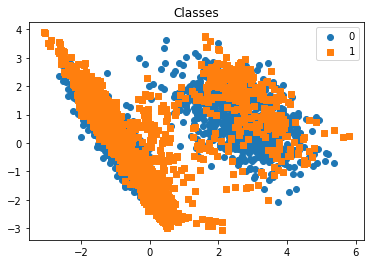

In [36]:
#Random_state and test_split
random_state = 1
test_split = 0.2

#Load data set
df, X, y = loadData()

#Split data set
X_train, X_val, X_test, y_train, y_val, y_test = splitData(X, y, test_split, random_state)

#Resample data set
# X_train, y_train = resample_dataset(X_train, y_train, random_state)
X_train, y_train = resample_SMOTE(X_train, y_train, random_state)

#Scale data set
X_train, X_val, X_test = scale(X_train, X_val, X_test)
plot_2d_space(X_train, y_train)

In [37]:
# The metrics we are going to test with to find the best metric
metrics = ["euclidean", "manhattan", "minkowski", "chebyshev"]
#euclidean, manhattan, chebyshev, minkowski, wminkowski, seuclidean, mahalanobis

#Best metric
# metric = "minkowski"
metric = best_metric(metrics, X_train, y_train, X_val, y_val) 

Metric:  euclidean  F1 score:  0.6806  Recall:  0.8442  Precision:  0.5702  Accuracy:  0.8858
Metric:  manhattan  F1 score:  0.6875  Recall:  0.8571  Precision:  0.5739  Accuracy:  0.8876
Metric:  minkowski  F1 score:  0.6806  Recall:  0.8442  Precision:  0.5702  Accuracy:  0.8858
Metric:  chebyshev  F1 score:  0.6468  Recall:  0.8442  Precision:  0.5242  Accuracy:  0.867
Best metric:  manhattan


Neighbours with minimum error:  1


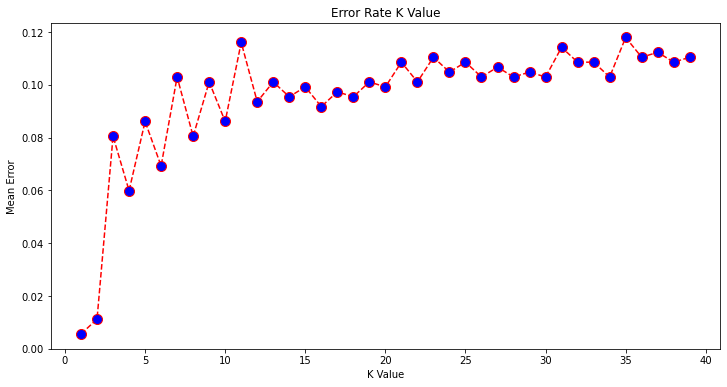

In [38]:
# find n: number of neighbours with minimum error rate
n = error_graph(X_train, y_train, X_val, y_val, metric)

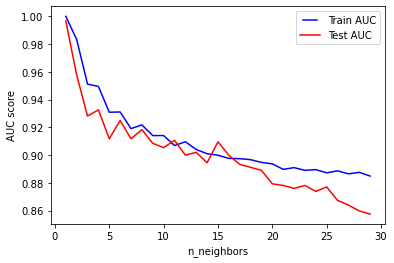

In [39]:
auc_score(X_train, y_train, X_val, y_val)

In [40]:
#Train classifier to find best K value
clf = train_classifier(X_train, y_train, n, metric)
#Cross validation score
cross_validation(clf, X_val, y_val, "accuracy")


Cross_validation score: 0.87



Classification report

              precision    recall  f1-score   support

   Not Churn       1.00      0.99      1.00       457
       Churn       0.96      1.00      0.98        77

    accuracy                           0.99       534
   macro avg       0.98      1.00      0.99       534
weighted avg       0.99      0.99      0.99       534



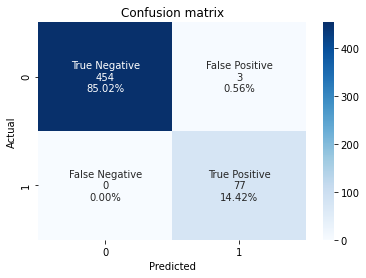

In [41]:
# Classification report
y_pred_val = clf.predict(X_val)
show_classification_report(y_val, y_pred_val)

# Test with test dataset


Classification report

              precision    recall  f1-score   support

   Not Churn       0.99      0.90      0.94       570
       Churn       0.62      0.96      0.76        97

    accuracy                           0.91       667
   macro avg       0.81      0.93      0.85       667
weighted avg       0.94      0.91      0.92       667



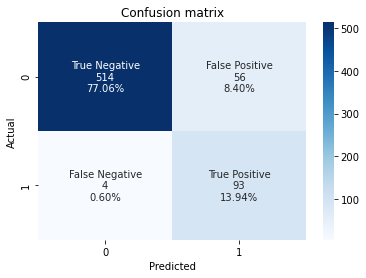

In [42]:
# Test with test values
clf = train_classifier(X_train, y_train, 5, metric)
accuracy = clf.score(X_test, y_test)
y_pred = clf.predict(X_test)
show_classification_report(y_test, y_pred)